In [2]:
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from NatMovie_utils import *
from wfield import *
from cor470 import enhance_df_f

sys.path.append('./ICA')
from jadeR import jadeR
from jadeR_cupy import jadeR_cupy

## batch process

In [3]:

path_list = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/','*/moving-bar/process/*-wfield'))
path_list

['/home/lzx/data/WF_VC_liuzhaoxi/24.05.14_H4/moving-bar/process/20240514-144010-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.06.20_H78/moving-bar/process/20240620-172655-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.06.20_H78/moving-bar/process/20240620-173003-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.07.08_Q20/moving-bar/process/20240708-191532-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/moving-bar/process/20241219-204729-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/moving-bar/process/20250110-013023-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/moving-bar/process/20250110-202214-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/moving-bar/process/20250110-214124-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/moving-bar/process/20250111-214213-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-071654-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-072327-wfield',
 '/home/lzx

In [4]:
path_list=path_list[4:]
path_list

['/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/moving-bar/process/20241219-204729-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/moving-bar/process/20250110-013023-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/moving-bar/process/20250110-202214-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/moving-bar/process/20250110-214124-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/moving-bar/process/20250111-214213-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-071654-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-072327-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/moving-bar/process/20250112-022646-wfield',
 '/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/moving-bar/process/20250112-022132-wfield']

In [ ]:
for path_wfield in path_list:
    print('\n\n\n'+path_wfield)
    experiment = os.path.basename(path_wfield)[:15]
    mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
    print(experiment, mouse)
    rawPath = pjoin(path_wfield, '../../raw')


    direction_list = ['right', 'down', 'left', 'up']
    stim_len = 47  # bar=48 dots=138

    # if not os.path.exists(pjoin(path_wfield, "trials.csv")):
    n_frame = min(len(os.listdir(pjoin(rawPath, experiment + "-405"))),
                len(os.listdir(pjoin(rawPath, experiment + "-470"))))
    stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
    stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
    stim_delay = int(stim_delay[0] / 100)
    stim = np.zeros(n_frame)
    for i in range(n_frame):
        stim[i] = stimfile[(i * 100 + stim_delay), 0]

    offset = np.where(np.diff(stim) == 1)[0] + 1
    onset = np.where(np.diff(stim) == -1)[0] + 1
    offset = offset[1:]
    offset = np.append(offset, onset[-1] + stim_len)
    trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset - onset), axis=1)
    np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
    # else:
    #     print("trials.csv of "+experiment+" has existed.")
    if len(onset) < 40:
        print("This experiment is not complete, skip.")
        continue
    path_out = pjoin(path_wfield, '..', experiment + '-mvbar--')
    os.makedirs(path_out, exist_ok=True)

    U = np.load(pjoin(path_wfield, 'U.npy')).astype('float32')
    # SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
    SVT = np.load(pjoin(path_wfield, 'SVT.npy')).astype('float32')
    SVT_470 = SVT[:, ::2]
    SVT_405 = SVT[:, 1::2]
    SVTcorr = SVT_470 - SVT_405
    frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
    trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
    seq = pd.read_csv('d4sequence.txt', header=None).values
    tif_height, tif_width = U.shape[:2]


    def sorting_4direct(SVT, trigger, seq, stim_len):
        """
        data: ndarray,
        trigger: the index of each trigger
        seq: ndarray
        """
        nSVD = SVT.shape[0]
        n_stim = np.unique(seq).size
        n_trigger = trigger.size
        n_rep = int(n_trigger / n_stim)
        if n_trigger != n_stim * n_rep:
            print('n_trigger != n_stim * n_rep')
            return
        SVT_sorted = np.zeros((nSVD, stim_len, n_stim, n_rep))
        for i_trigger in range(n_trigger):
            i_rep = int(i_trigger / n_stim)
            SVT_sorted[:nSVD, :stim_len, seq[i_trigger] // 90, i_rep] = SVT[:,
                                                                        trigger[i_trigger]:trigger[i_trigger] + stim_len]

        return SVT_sorted.astype('float16')


    # SVTcorr_sort维度：[nSVD, stim_len, n_stim, n_rep]
    SVTcorr_sort = sorting_4direct(SVTcorr, trialfile[:, 1], seq[:, 0], stim_len).astype('float32')
    n_stim = SVTcorr_sort.shape[2]
    n_rep = SVTcorr_sort.shape[3]
    width, height = U.shape[0:2]

    # tif_sort维度：[height, width, stim_len, n_stim, n_rep]
    tif_sort = np.tensordot(U, SVTcorr_sort, axes=(2, 0)).astype('float32')
    tif_mean = np.mean(tif_sort, axis=-1)
    tif_with_mean = np.concatenate((tif_mean[..., np.newaxis], tif_sort), axis=-1)
    tif_rep_reshape = np.concatenate(np.split(tif_with_mean, tif_with_mean.shape[-1], axis=-1),
                                    axis=1).squeeze().transpose(2, 0, 1, 3)

    n_rep = tif_sort.shape[-1]
    print('tif_sort.shape: (height, width, stim_len, n_dir, n_rep) ', tif_sort.shape)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_tif_sort.npy'), tif_sort)
    print('finish save tif_sort.npy')

    path_tif = pjoin(path_out, f'{mouse}_{experiment}_tif')
    os.makedirs(path_tif, exist_ok=True)

    for i_dir in range(n_stim):
        print('start processing {}-{}'.format(i_dir + 1, direction_list[i_dir]))
        imwrite(pjoin(path_tif, direction_list[i_dir] + '-rep-reshape.tif'),
                tif_rep_reshape[:, :, :, i_dir].astype('float32'), imagej=True)
    print('export all rep-reshape-tifs')

    for i_dir in range(n_stim):
        print('start processing {}-{}'.format(i_dir + 1, direction_list[i_dir]))
        imwrite(pjoin(path_tif, direction_list[i_dir] + '-avg.tif'),
                tif_mean[:, :, :, i_dir].transpose(2, 0, 1).astype('float32'), imagej=True)
    print('export all avg-tifs')

    for i_dir in range(n_stim):
        print('start processing {}-{}'.format(i_dir + 1, direction_list[i_dir]))
        tif = pjoin(path_tif, direction_list[i_dir] + '-avg.tif')
        img = imread(tif)
        img_enhance = enhance_df_f(img, frames_average[0])
        imwrite(tif[:-4] + '-enhance.tif', img_enhance.astype('uint16'), imagej=True)
        # print('finish'+tif[:-4]+'-enhance.tif')
    print('export all avg-enhance-tifs')

    # prepare Allen ccf map

    lmarks = load_allen_landmarks(pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'))
    ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
    # this loads the untransformed atlas
    atlas_im, areanames, brain_mask = atlas_from_landmarks_file(
        pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'),
        do_transform=True)
    # this converts the reference to image space (unwarped)
    ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                            resolution=lmarks['resolution'],
                                            bregma_offset=lmarks['bregma_offset'])

    from skimage.transform import warp

    warped_height, warped_width = (540, 640)
    ccf_regions = allen_transform_regions(None, ccf_regions_reference,
                                        resolution=lmarks['resolution'],
                                        bregma_offset=lmarks['bregma_offset'])

    frames_average_warped = warp(frames_average.transpose(1, 2, 0), lmarks['transform'],
                                order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                output_shape=(warped_height, warped_width)).transpose(2, 0, 1)

    # %% plot ccf map on average frame

    frames_ave = np.load(pjoin(path_wfield, 'frames_average.npy'))[0]
    merge_frame_size = (512, 512)  # (width, height)
    fig = plt.figure(figsize=(merge_frame_size[0] / 128, merge_frame_size[1] / 128), dpi=128)
    plt.imshow(frames_ave, cmap='gray')
    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=5, alpha=1, ha='center')

    plt.axis('off')
    fig.set_facecolor('white')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    # %% plot warped average frame

    fig = plt.figure(figsize=(warped_height / 128, warped_width / 128), dpi=128)
    plt.imshow(frames_average_warped[0], cmap='gray')
    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=5, alpha=1, ha='center')

    plt.axis('off')
    fig.set_facecolor('white')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    path_ccf_stim = pjoin(path_out, f'{mouse}_{experiment}_avg-ccf-stim')
    os.makedirs(path_ccf_stim, exist_ok=True)

    for direction in ['up', 'down', 'left', 'right']:
        stim_file = pjoin(r'/home/lzx/data/WF_VC_liuzhaoxi/code/WF/others', 'moving-bar-' + direction + '.mp4')
        tif_avg = pjoin(path_tif, direction + '-avg' + '.tif')
        avg_ccf_stim_file = pjoin(path_ccf_stim, os.path.basename(tif_avg)[:-4] + '-ccf-stim.mp4')
        merge_ccf_stim(avg_ccf_stim_file, tif_avg, ccf_regions_im, stim_file=stim_file, tif_fps=10, trial_rep=1,
                    vmin=-0.04, vmax=0.04, text=direction + '-avg ')
    print('\nfinish all avg merging')

    # for direction in ['up', 'down', 'left', 'right']:
    #     stim_file = pjoin(r'/home/lzx/data/WF_VC_liuzhaoxi/code/WF/others', 'moving-bar-' + direction + '.mp4')
    #     tif_avg = pjoin(path_out, 'tif', direction + '-avg-enhance' + '.tif')
    #     avg_ccf_stim_file = pjoin(path_ccf_stim, os.path.basename(tif_avg)[:-4] + '-ccf-stim.mp4')
    #     merge_ccf_stim(avg_ccf_stim_file, tif_avg, ccf_regions_im, stim_file=stim_file, tif_fps=10, trial_rep=1,
    #                    vmin=200, vmax=25000, text=direction + '-avg ')
    # print('\nfinish all avg merging')


    snr = cal_snr(tif_sort, axis1=4, axis2=2)
    # snr=np.load(pjoin(path_out, f'{mouse}_{experiment}_snr.npy'))
    np.save(pjoin(path_out, f'{mouse}_{experiment}_snr.npy'), snr)
    subplot_movie_heatmap(snr, 2, 2, direction_list, path_outfile=pjoin(path_out, f'{mouse}_{experiment}_snr'),
                        title=f'{mouse}_{experiment}_moving-bar SNR', vmin=None, vmax=None,
                        cmap='hot', pixel_um=26, ccf_regions=ccf_regions_im)

    # snr_filter = median_filter(snr,2)
    # subplot_movie_heatmap(snr_filter, 2, 2, direction_list, path_outfile=pjoin(path_out,'moving-bar filter snr'), title='moving-bar filter snr', vmin=None, vmax=None,
    #                       cmap='hot', pixel_um=26)

    std = np.std(tif_sort, axis=(2, 4))
    # std=np.load(pjoin(path_out, f'{mouse}_{experiment}_std.npy'))
    np.save(pjoin(path_out, f'{mouse}_{experiment}_std.npy'), std)
    subplot_movie_heatmap(std, 2, 2, direction_list, path_outfile=pjoin(path_out, f'{mouse}_{experiment}_std'),
                        title=f'{mouse}_{experiment}_moving-bar std', vmin=None, vmax=0.1,
                        cmap='hot', pixel_um=26, ccf_regions=ccf_regions_im)

    snr_warped = warp(snr, lmarks['transform'],
                    order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                    output_shape=(warped_height, warped_width))
    np.save(pjoin(path_out, f'{mouse}_{experiment}_snr_warped.npy'), snr_warped)
    subplot_movie_heatmap(snr_warped, 2, 2, direction_list,
                        path_outfile=pjoin(path_out, f'{mouse}_{experiment}_snr_warped'),
                        title=f'{mouse}_{experiment}_moving-bar SNR_warped',
                        vmin=None, vmax=None, cmap='hot', pixel_um=26, ccf_regions=ccf_regions)

    std_warped = warp(std, lmarks['transform'],
                    order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                    output_shape=(warped_height, warped_width))
    np.save(pjoin(path_out, f'{mouse}_{experiment}_std_warped.npy'), std_warped)
    subplot_movie_heatmap(std_warped, 2, 2, direction_list,
                        path_outfile=pjoin(path_out, f'{mouse}_{experiment}_std_warped'),
                        title=f'{mouse}_{experiment}_moving-bar std_warped',
                        vmin=None, vmax=0.1, cmap='hot', pixel_um=26, ccf_regions=ccf_regions)


    def flat_mask(Uflat, xy):
        # index are in xy, like what np.where(mask) returns
        x = np.array(np.clip(xy[0], 0, tif_height - 1), dtype=int)
        y = np.array(np.clip(xy[1], 0, tif_width - 1), dtype=int)
        idx = np.ravel_multi_index((x, y), (tif_height, tif_width))
        t = Uflat[idx, :]
        return t


    tif_sort_flat = tif_sort.reshape(tif_height * tif_width, -1)
    all_area_timecourse = np.empty((33, tif_sort_flat.shape[-1]))
    for area in range(1, 34):
        all_area_timecourse[area - 1] = flat_mask(tif_sort_flat, np.where(atlas_im == area)).mean(axis=0)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all_area_timecourse.npy'), all_area_timecourse.reshape(33, *SVTcorr_sort.shape[1:]))


    area_list = ['MOB', 'FRP', 'MOp', 'MOs', 'SSp-n', 'SSp-m', 'SSp-un', 'PL', 'ACAd', 'RSPv', 'RSPd', 'RSPagl', 'VISC',
                'SSs', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'TEa', 'AUDd', 'AUDp', 'AUDpo', 'AUDv',
                'VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'VISp']

    area_list1 = ['MOB', 'FRP', 'MOp', 'MOs', 'PL', 'ACAd', 'RSPv', 'RSPd', 'RSPagl', 'VISC',
                'SSp-n', 'SSp-m', 'SSp-un', 'SSs', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'TEa', 'AUDd', 'AUDp',
                'AUDpo', 'AUDv',
                'VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'VISp']

    area_idx = [area_list.index(area) for area in area_list1]

    print(area_idx)
    from scipy.signal import correlate
    import numpy as np


    def compute_lag_correlation(matrix):
        """
        计算矩阵中每一行之间的归一化 lag correlation 和对应滞后。

        参数:
            matrix (numpy.ndarray): 输入二维矩阵，形状为 (n_rows, n_cols)

        返回:
            max_corr_matrix (numpy.ndarray): 最大绝对值相关性矩阵，形状为 (n_rows, n_rows)
            max_lag_matrix (numpy.ndarray): 最大相关性对应的滞后矩阵，形状为 (n_rows, n_rows)
        """
        n_rows = matrix.shape[0]
        max_corr_matrix = np.zeros((n_rows, n_rows))
        max_lag_matrix = np.zeros((n_rows, n_rows))

        for i in range(n_rows):
            for j in range(i, n_rows):  # 只计算上三角矩阵
                # 提取信号
                x = matrix[i]
                y = matrix[j]

                # 零均值处理
                x = x - np.mean(x)
                y = y - np.mean(y)

                # 计算 cross-correlation
                corr = correlate(x, y, mode='full', method='auto')

                # 归一化：除以 (std(x) * std(y) * len(x))
                normalization_factor = np.std(x) * np.std(y) * len(x)
                corr /= normalization_factor  # 将结果限制在 [-1, 1]

                # 找到最大绝对值相关性
                max_corr_idx = np.argmax(np.abs(corr))
                max_corr = corr[max_corr_idx]
                lag = max_corr_idx - (len(x) - 1)

                # 填入矩阵
                max_corr_matrix[i, j] = max_corr
                max_corr_matrix[j, i] = max_corr  # 对称性
                max_lag_matrix[i, j] = lag
                max_lag_matrix[j, i] = -lag  # 滞后是反对称的

        return max_corr_matrix, max_lag_matrix


    # 调用函数
    area_corr, area_lag = compute_lag_correlation(all_area_timecourse[area_idx])
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all area correlation.npy'), area_corr)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all area correlation lag.npy'), area_lag)



    plot_heatmap(area_corr, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None,
                title=f'{experiment}_{mouse}_all area correlation',
                outfile=pjoin(path_out, f'{mouse}_{experiment}_all area correlation.png'), dpi=300, annot=True)
    plot_heatmap(area_lag, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None,
                title=f'{experiment}_{mouse}_all area correlation lag',
                outfile=pjoin(path_out, f'{mouse}_{experiment}_all area correlation lag.png'), dpi=300, annot=True)




    ## spatial ICA ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    path_out = pjoin(path_out, f'{mouse}_{experiment}_ICA')
    os.makedirs(path_out, exist_ok=True)
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    import cupy as cp

    cp._default_memory_pool.free_all_blocks()
    # set ICA parameter

    ICA_methods = 'jade'
    n_IC = 20

    tif_sort_flat = tif_sort.reshape(tif_height * tif_width, -1)
    X = cp.asarray(tif_sort_flat.T)

    print('ICA dim:', X.shape)

    if ICA_methods == 'jade':
        demix_matrix = jadeR_cupy(X, m=n_IC, verbose=True)
        IC = demix_matrix @ X
        IC_array = cp.asnumpy(IC).reshape(n_IC, *U.shape[:-1])
        mix_matrix = cp.asnumpy(cp.linalg.pinv(demix_matrix))

        del X, demix_matrix, IC
        cp._default_memory_pool.free_all_blocks()

    elif ICA_methods == 'fast':
        from sklearn.decomposition import FastICA

        tif_corr_bin2 = tif_corr.reshape(tif_corr.shape[0], tif_corr.shape[1] // 2, 2, tif_corr.shape[2] // 2, 2).mean(
            axis=(2, 4))
        X_bin2 = tif_corr_bin2.reshape(tif_corr.shape[0], -1)
        fastica = FastICA(n_components=n_IC, whiten="arbitrary-variance")
        IC = fastica.fit_transform(X_bin2.T).T
        mix_matrix = fastica.mixing_
        IC_array_bin2 = np.asarray(IC).reshape(n_IC, *tif_corr_bin2.shape[1:])
        IC_array = np.kron(IC_array_bin2, np.ones((1, 2, 2)))

    mix_matrix_sort = mix_matrix.T.reshape(n_IC, *tif_sort.shape[2:])
    np.save(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}.npy'), IC_array)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_mix_matrix_sort.npy'), mix_matrix_sort)
    print('save ICA matrix')
    print('IC_array.shape', IC_array.shape)
    print('mix_matrix_sort.shape: (n_IC, n_frame, n_dir, n_rep) ', mix_matrix_sort.shape)


    # set IC threshold, adjust ± sign

    def zscore(matrix, axis=(1, 2)):
        mean = np.mean(matrix, axis=axis)
        std = np.std(matrix, axis=axis)
        zscore_matrix = (matrix - mean[:, None, None]) / std[:, None, None]
        return zscore_matrix


    IC_arrayz = zscore(IC_array)
    IC_arrayz_cut = np.copy(IC_arrayz)

    z_cut = 3
    IC_arrayz_cut[np.abs(IC_arrayz_cut) < z_cut] = 0
    # IC_arrayz_cut[np.abs(IC_arrayz_cut) >= z_cut] = 1
    ic_sign = np.where(np.mean(IC_arrayz_cut, axis=(1, 2)) < 0, -1, 1)
    IC_arrayz_cut = ic_sign[:, None, None] * IC_arrayz_cut  # 确保IC方向为正
    mix_matrix = ic_sign * mix_matrix


    ##find cluster

    def find_cluster(binary_image, area):
        """

        binary_image: (size1,size2),is a 2D matrix that has already been binarized
        area: int, the minimum area of the cluster,50~100 is a good choice for me
        """
        from scipy.ndimage import label, find_objects
        labeled_array, cluster_num = label(binary_image)
        print(f'cluster_num: {cluster_num}')
        objects = find_objects(labeled_array)
        new_binary_image = np.zeros_like(binary_image)
        for i in range(1, cluster_num + 1):
            cluster = (labeled_array == i)
            new_binary_image[cluster] = cluster.sum() >= area
        return new_binary_image


    IC_arrayz_cut_cluster = np.zeros((n_IC, tif_height, tif_width))
    for iIC in range(n_IC):
        IC_arrayz_cut_cluster[iIC] = find_cluster(IC_arrayz_cut[iIC], 100)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster.npy'), IC_arrayz_cut_cluster)


    # plot spatial IC

    nrow = 4
    ncol = 5
    dpi = 200

    fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_ave, cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
            ax[irow, icol].axis('off')

            for idx, r in ccf_regions_im.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC} (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    # from skimage.transform import warp

    # warped_height, warped_width = (540, 640)
    # ccf_regions = allen_transform_regions(None,ccf_regions_reference,
    #                                       resolution = lmarks['resolution'],
    #                                         bregma_offset = lmarks['bregma_offset'])

    IC_arrayz_cut_cluster_warped = warp(IC_arrayz_cut_cluster.transpose(1, 2, 0), lmarks['transform'],
                                        order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                        output_shape=(warped_height, warped_width)).transpose(2, 0, 1)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster_warped.npy'), IC_arrayz_cut_cluster_warped)

    # frames_average_warped = warp(frames_average.transpose(1,2,0),lmarks['transform'],
    #                 order = 1, mode='constant', cval = 0, clip=True, preserve_range=True, output_shape=(warped_height, warped_width)).transpose(2,0,1)

    # plot warped spatial IC

    nrow = 4
    ncol = 5
    dpi = 200

    fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_average_warped[0], cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster_warped[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
            ax[irow, icol].axis('off')

            for idx, r in ccf_regions.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC}_warped (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_spatial-IC{n_IC}_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()

    # plot superimposed spatial IC

    from matplotlib.colors import ListedColormap

    color_list = [
        "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8",
        "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6",
        "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD",
        "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA",
        "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700",
        "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1",
        "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1",
        "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9",
        "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
    ]

    fig, ax = plt.subplots()
    plt.imshow(frames_ave, cmap='gray')

    # 逐个叠加IC，使用不同颜色
    for i in range(n_IC):
        cmap = ListedColormap(['None', color_list[i]])
        plt.imshow(IC_arrayz_cut_cluster[i], cmap=cmap, interpolation='nearest', alpha=0.5)

    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')

    # plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
    #                  borderWidth=1, isColor=True, plotName=True, fontSize=7)

    plt.axis('off')
    # plt.colorbar()
    fig.set_facecolor('white')
    plt.title(f'{mouse} {experiment}\nsum spatial_IC-{n_IC}(cut={z_cut})')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_sum spatial-IC-{n_IC}___colored.png'), bbox_inches='tight',
                pad_inches=0)
    plt.show()
    # plot warped superimposed spatial IC

    from matplotlib.colors import ListedColormap

    color_list = [
        "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8",
        "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6",
        "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD",
        "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA",
        "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700",
        "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1",
        "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1",
        "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9",
        "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
    ]

    fig, ax = plt.subplots()
    plt.imshow(frames_average_warped[0], cmap='gray')

    # 逐个叠加IC，使用不同颜色
    for i in range(n_IC):
        cmap = ListedColormap(['None', color_list[i]])
        plt.imshow(IC_arrayz_cut_cluster_warped[i], cmap=cmap, interpolation='nearest', alpha=0.5)

    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')

    # plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
    #                  borderWidth=1, isColor=True, plotName=True, fontSize=7)

    plt.axis('off')
    # plt.colorbar()
    fig.set_facecolor('white')
    plt.title(f'{mouse}_{experiment}\nsum IC{n_IC}(cut={z_cut})')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_sum IC{n_IC}___colored_warped.png'), bbox_inches='tight',
                pad_inches=0)
    plt.show()
    # align timecourse


    # mix_matrix.T: [n_IC, n_frame] 
    # timecourse: [n_IC, n_frame, n_movie, n_rep]

    # timecourse = sorting_4direct(mix_matrix.T, trialfile[:, 1], seq[:, 0], stim_len).astype('float32')
    timecourse = mix_matrix.T.reshape(n_IC, *tif_sort.shape[2:])
    print('timecourse.shape: (n_IC, n_frame, n_dir, n_rep) ', timecourse.shape)
    # n_rep = timecourse.shape[-1]
    # timecourse_mean = np.mean(timecourse, axis=3)

    # select top10 SNR ICs.

    timecourse_snr = cal_snr(timecourse, axis1=3, axis2=1)
    print('timecourse_snr.shape', timecourse_snr.shape)

    IC_idx = np.argsort(np.mean(timecourse_snr, axis=1))[::-1]
    timecourse_snr1 = timecourse_snr[IC_idx]

    plot_heatmap(timecourse_snr.T, xlabel=range(1, n_IC + 1), ylabel=direction_list, cmap='coolwarm',
                title=f'{mouse}_{experiment} ICA-{n_IC}_snr', dpi=300, annot=False,
                outfile=pjoin(path_out, f'{mouse}_{experiment} ICA-{n_IC}_snr.png'))
    plot_heatmap(timecourse_snr1.T, xlabel=IC_idx + 1, ylabel=direction_list, cmap='coolwarm',
                title=f'{mouse}_{experiment} ICA-{n_IC}_snr1', dpi=300, annot=False,
                outfile=pjoin(path_out, f'{mouse}_{experiment} ICA-{n_IC}_snr1.png'))

    timecourse1 = timecourse[IC_idx[:10]].transpose(0, 2, 1, 3)
    print('timecourse1.shape', timecourse1.shape)
    # plot top10 spatial IC

    IC_arrayz_cut1 = IC_arrayz_cut[IC_idx]

    nrow = 4
    ncol = 5
    dpi = 200

    fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_ave, cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut1[iIC], cmap='coolwarm', clim=[-5, 5], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(IC_idx[iIC] + 1), fontsize=10)
            ax[irow, icol].axis('off')

            for idx, r in ccf_regions_im.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse}_{experiment}\ntop10 spatial IC-{n_IC} (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment} top10 spatial IC-{n_IC}.png'), bbox_inches='tight', pad_inches=0)
    plt.show()


    subplot_timecourse(timecourse1, IC_idx + 1, direction_list, title=f'{mouse}_{experiment} top10 ICA-{n_IC}_timecourse',
                    outpath=path_out, pre_length=0, n_frame=stim_len, plot_rep=False, dpi=200)



In [4]:
for path_wfield in path_list:
    # print('\n\n\n'+path_wfield)
    experiment = os.path.basename(path_wfield)[:15]
    mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
    print('\n'+experiment, mouse)
    path_out = pjoin(path_wfield, '..', experiment + '-mvbar--')

    os.rename(pjoin(path_out, 'tif_sort.npy'), pjoin(path_out, f'{mouse}_{experiment}_tif_sort.npy'))
    print(f'Renamed {mouse}_{experiment}_tif_sort.npy')



20241219-204729 P41
Renamed P41_20241219-204729_tif_sort.npy

20250110-013023 P41
Renamed P41_20250110-013023_tif_sort.npy

20250110-202214 U26
Renamed U26_20250110-202214_tif_sort.npy

20250110-214124 U27
Renamed U27_20250110-214124_tif_sort.npy

20250111-214213 U26
Renamed U26_20250111-214213_tif_sort.npy

20250112-071654 Q12
Renamed Q12_20250112-071654_tif_sort.npy

20250112-072327 Q12
Renamed Q12_20250112-072327_tif_sort.npy

20250112-022646 U27
Renamed U27_20250112-022646_tif_sort.npy

20250112-022132 U27
Renamed U27_20250112-022132_tif_sort.npy


## load summary parameter

In [18]:
path_summary = '/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary2/moving-bar'
os.makedirs(path_summary, exist_ok=True)

In [19]:
direction_list = ['right', 'down', 'left', 'up']


In [20]:
warped_height, warped_width = (540, 640)

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
lmarks = load_allen_landmarks(None)

# this converts to warped image space
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

atlas, areanames, brain_mask = atlas_from_landmarks_file(landmarks_file=None, reference='dorsal_cortex', dims = [warped_height, warped_width], do_transform = None) 

In [ ]:

area_list = ['MOB','FRP','MOp','MOs','SSp-n','SSp-m','SSp-un','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']


## summary SNR

In [21]:

path_snr_ls = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/*/moving-bar/process', '*-mvbar--', '*snr_warped.npy'))
print(f'{len(path_snr_ls)} snr_warped.npy\n\n'+'\n'.join(path_snr_ls))


9 snr_warped.npy

/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/moving-bar/process/20241219-204729-mvbar--/P41_20241219-204729_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/moving-bar/process/20250110-013023-mvbar--/P41_20250110-013023_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/moving-bar/process/20250110-202214-mvbar--/U26_20250110-202214_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/moving-bar/process/20250110-214124-mvbar--/U27_20250110-214124_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/moving-bar/process/20250111-214213-mvbar--/U26_20250111-214213_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-071654-mvbar--/Q12_20250112-071654_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-072327-mvbar--/Q12_20250112-072327_snr_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/moving-bar/process/20250112-022646-mvbar--/U27_20250112-022646_snr_warped.npy
/home/

In [65]:
## cal all snr

snr_list = [np.load(path_snr) for path_snr in path_snr_ls]
snr_array = np.asarray(snr_list)
print('snr_array.shape', snr_array.shape)
np.save(pjoin(path_summary,'all_snr.npy'), snr_array)

n_experiment, warped_height, warped_width, n_stim = snr_array.shape



snr_array.shape (9, 540, 640, 4)


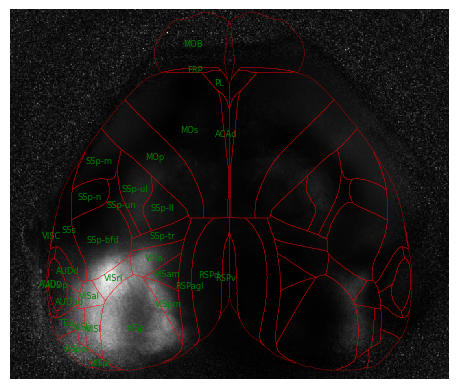

In [28]:
# plot warped avg_frame & CCF

fig = plt.figure()
plt.imshow(snr_array[0,:,:,0], cmap='gray')
# plt.imshow(brain_mask, cmap='gray')

for i, r in ccf_regions.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=6, alpha=1, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.show()

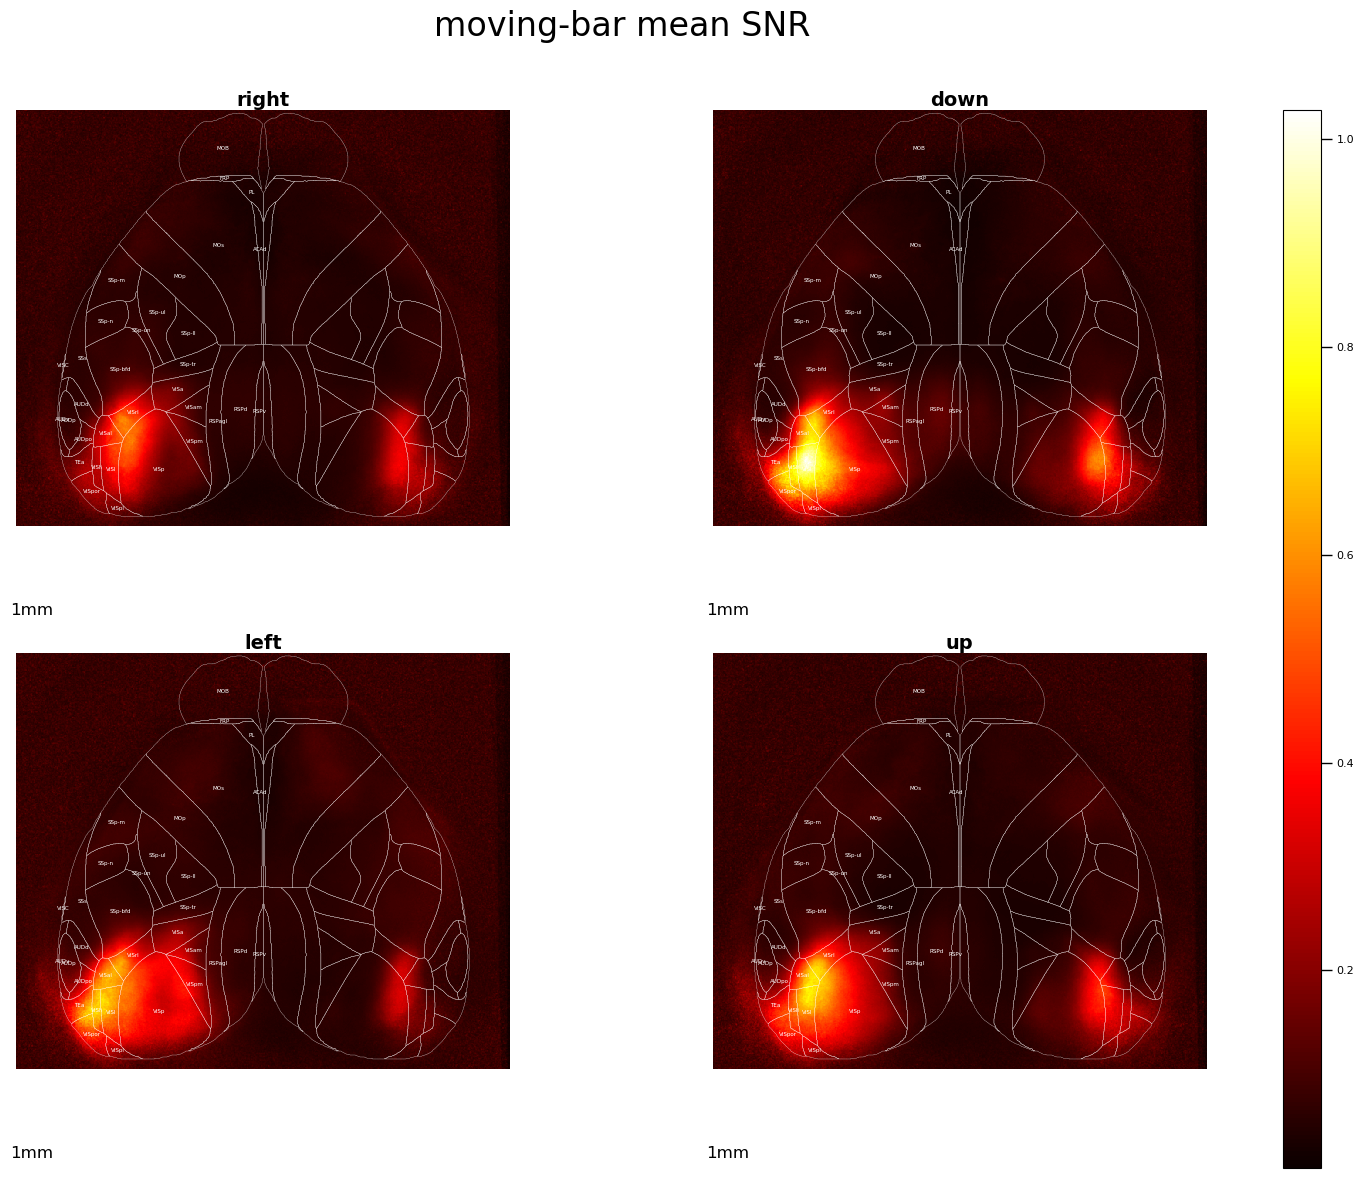

In [29]:
subplot_movie_heatmap(snr_array.mean(axis=0), 2, 2, direction_list, path_outfile=pjoin(path_summary, 'mean_snr.png'), title='moving-bar mean SNR', 
                      vmin=None, vmax=None, cmap='hot', pixel_um=26,ccf_regions=ccf_regions)


In [30]:
def flat_mask_warped(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,warped_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,warped_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(warped_height, warped_width))
    t = Uflat[idx,:]
    return t

snr_array_flat= snr_array.transpose(1,2,0,3).reshape(warped_height*warped_width, n_experiment*n_stim)
all_area_snr =np.empty((33, snr_array_flat.shape[-1]))

for area in range(1,34):
    all_area_snr[area-1] = flat_mask_warped(snr_array_flat, np.where(atlas == area)).mean(axis=0)
all_area_snr = all_area_snr.reshape(33, n_experiment, n_stim)

np.save(pjoin(path_summary, 'all_area_snr.npy'), all_area_snr)

/tmp/ipykernel_3935390/2905529241.py:18: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='snr', data=df_long, order=None, scale='width', inner='quartile', color='steelblue')   # 绘制小提琴图


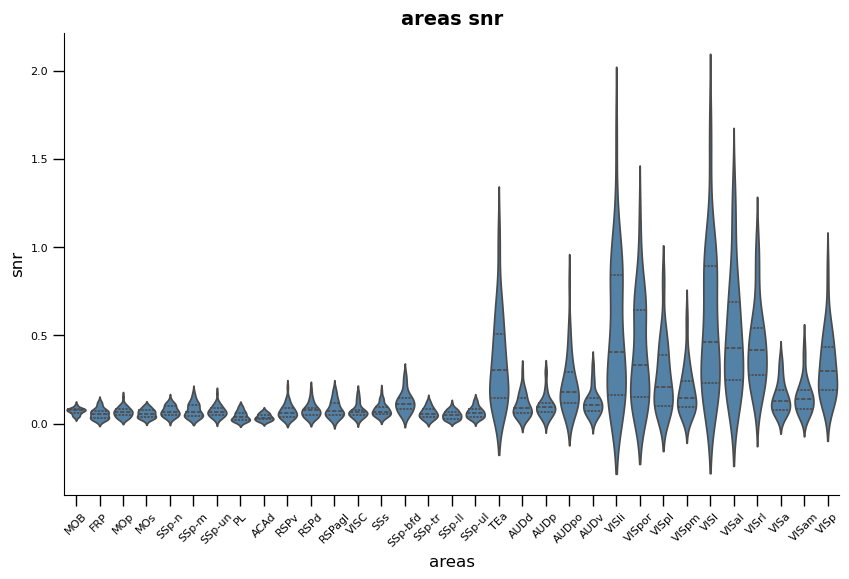

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 将矩阵转换为 DataFrame
df = pd.DataFrame(all_area_snr.reshape(33, -1).T, columns=area_list)

# 将数据转换为长格式
df_long = df.melt(var_name='areas', value_name='snr')

# 按每组的平均值对分组排序
group_order = df.mean(axis=0).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
# sns.boxplot(x='areas', y='snr', data=df_long, order=group_order)
# sns.violinplot(x='areas', y='snr', data=df_long, order=group_order, scale='width', inner='quartile')   # 绘制小提琴图
sns.violinplot(x='areas', y='snr', data=df_long, order=None, scale='width', inner='quartile', color='steelblue')   # 绘制小提琴图
plt.title('areas snr')
plt.xlabel('areas')
plt.ylabel('snr')
plt.xticks(rotation=45)
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
# plt.savefig(pjoin(path_summary, 'all areas snr rank.png'), facecolor='white', transparent=False)
plt.savefig(pjoin(path_summary, 'all areas snr.png'), facecolor='white', transparent=False)
plt.show()


/tmp/ipykernel_3935390/166140824.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')     # 绘制小提琴图
/tmp/ipykernel_3935390/166140824.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')     # 绘制小提琴图
/tmp/ipykernel_3935390/166140824.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')     # 绘制小提琴图
/tmp/ipykernel_3935390/166140824.py:13: FutureWar

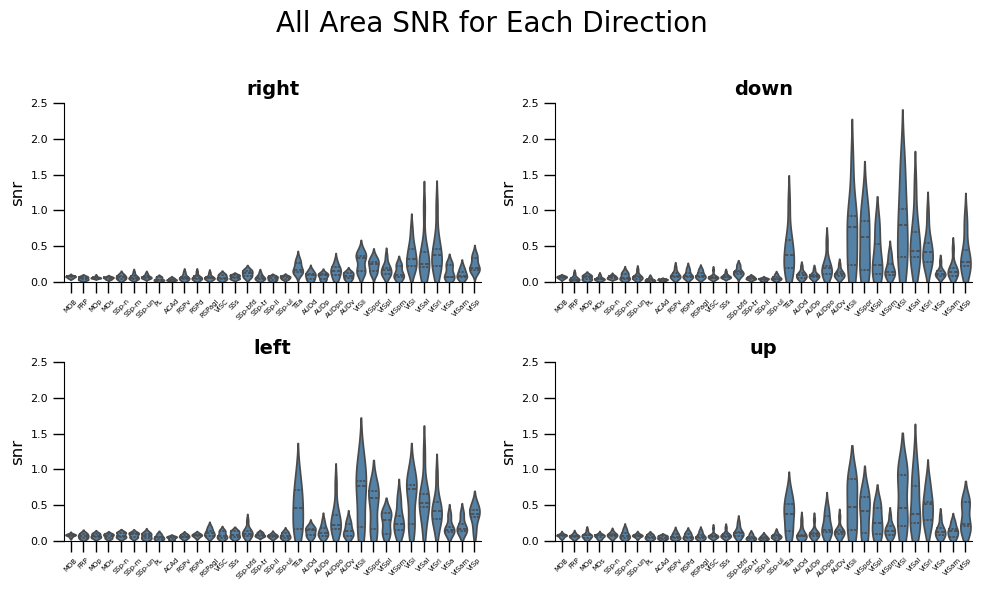

In [44]:
# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()  # 将 axes 二维数组展平，便于迭代
for i in range(n_stim):  # 遍历第三维的每个小图
    # 提取当前小图对应的数据
    matrix = all_area_snr[:, :, i]
    df = pd.DataFrame(matrix.T, columns=area_list)
    
    # 转换为长格式
    df_long = df.melt(var_name='areas', value_name='snr')

    # sns.boxplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i])
    sns.violinplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')     # 绘制小提琴图
    axes[i].set_title(direction_list[i])  # 设置小标题
    axes[i].set_xlabel('')  # 隐藏 x 轴标签以节省空间
    axes[i].set_ylabel('snr')
    axes[i].set_ylim(0, 2.5)  # 设置统一 y 轴范围
    axes[i].tick_params(axis='x', rotation=45, labelsize=5)  # 调整刻度角度和字体大小
    # for label in axes[i].get_xticklabels():
    #     label.set_ha('right')  # 设置 x 轴标签右对齐

# 删除多余的子图（仅 14 个小图）
for j in range(14, len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('All Area SNR for Each Direction', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'all_areas_snr_per_direction_unified_y_violin.png'), facecolor='white', transparent=False)
plt.show()


/tmp/ipykernel_3935390/677307335.py:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Movies', y='SNR', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')
/tmp/ipykernel_3935390/677307335.py:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Movies', y='SNR', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')
/tmp/ipykernel_3935390/677307335.py:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Movies', y='SNR', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')
/tmp/ipykernel_3935390/677307335.py:16: FutureWarning: 

The `scale` paramet

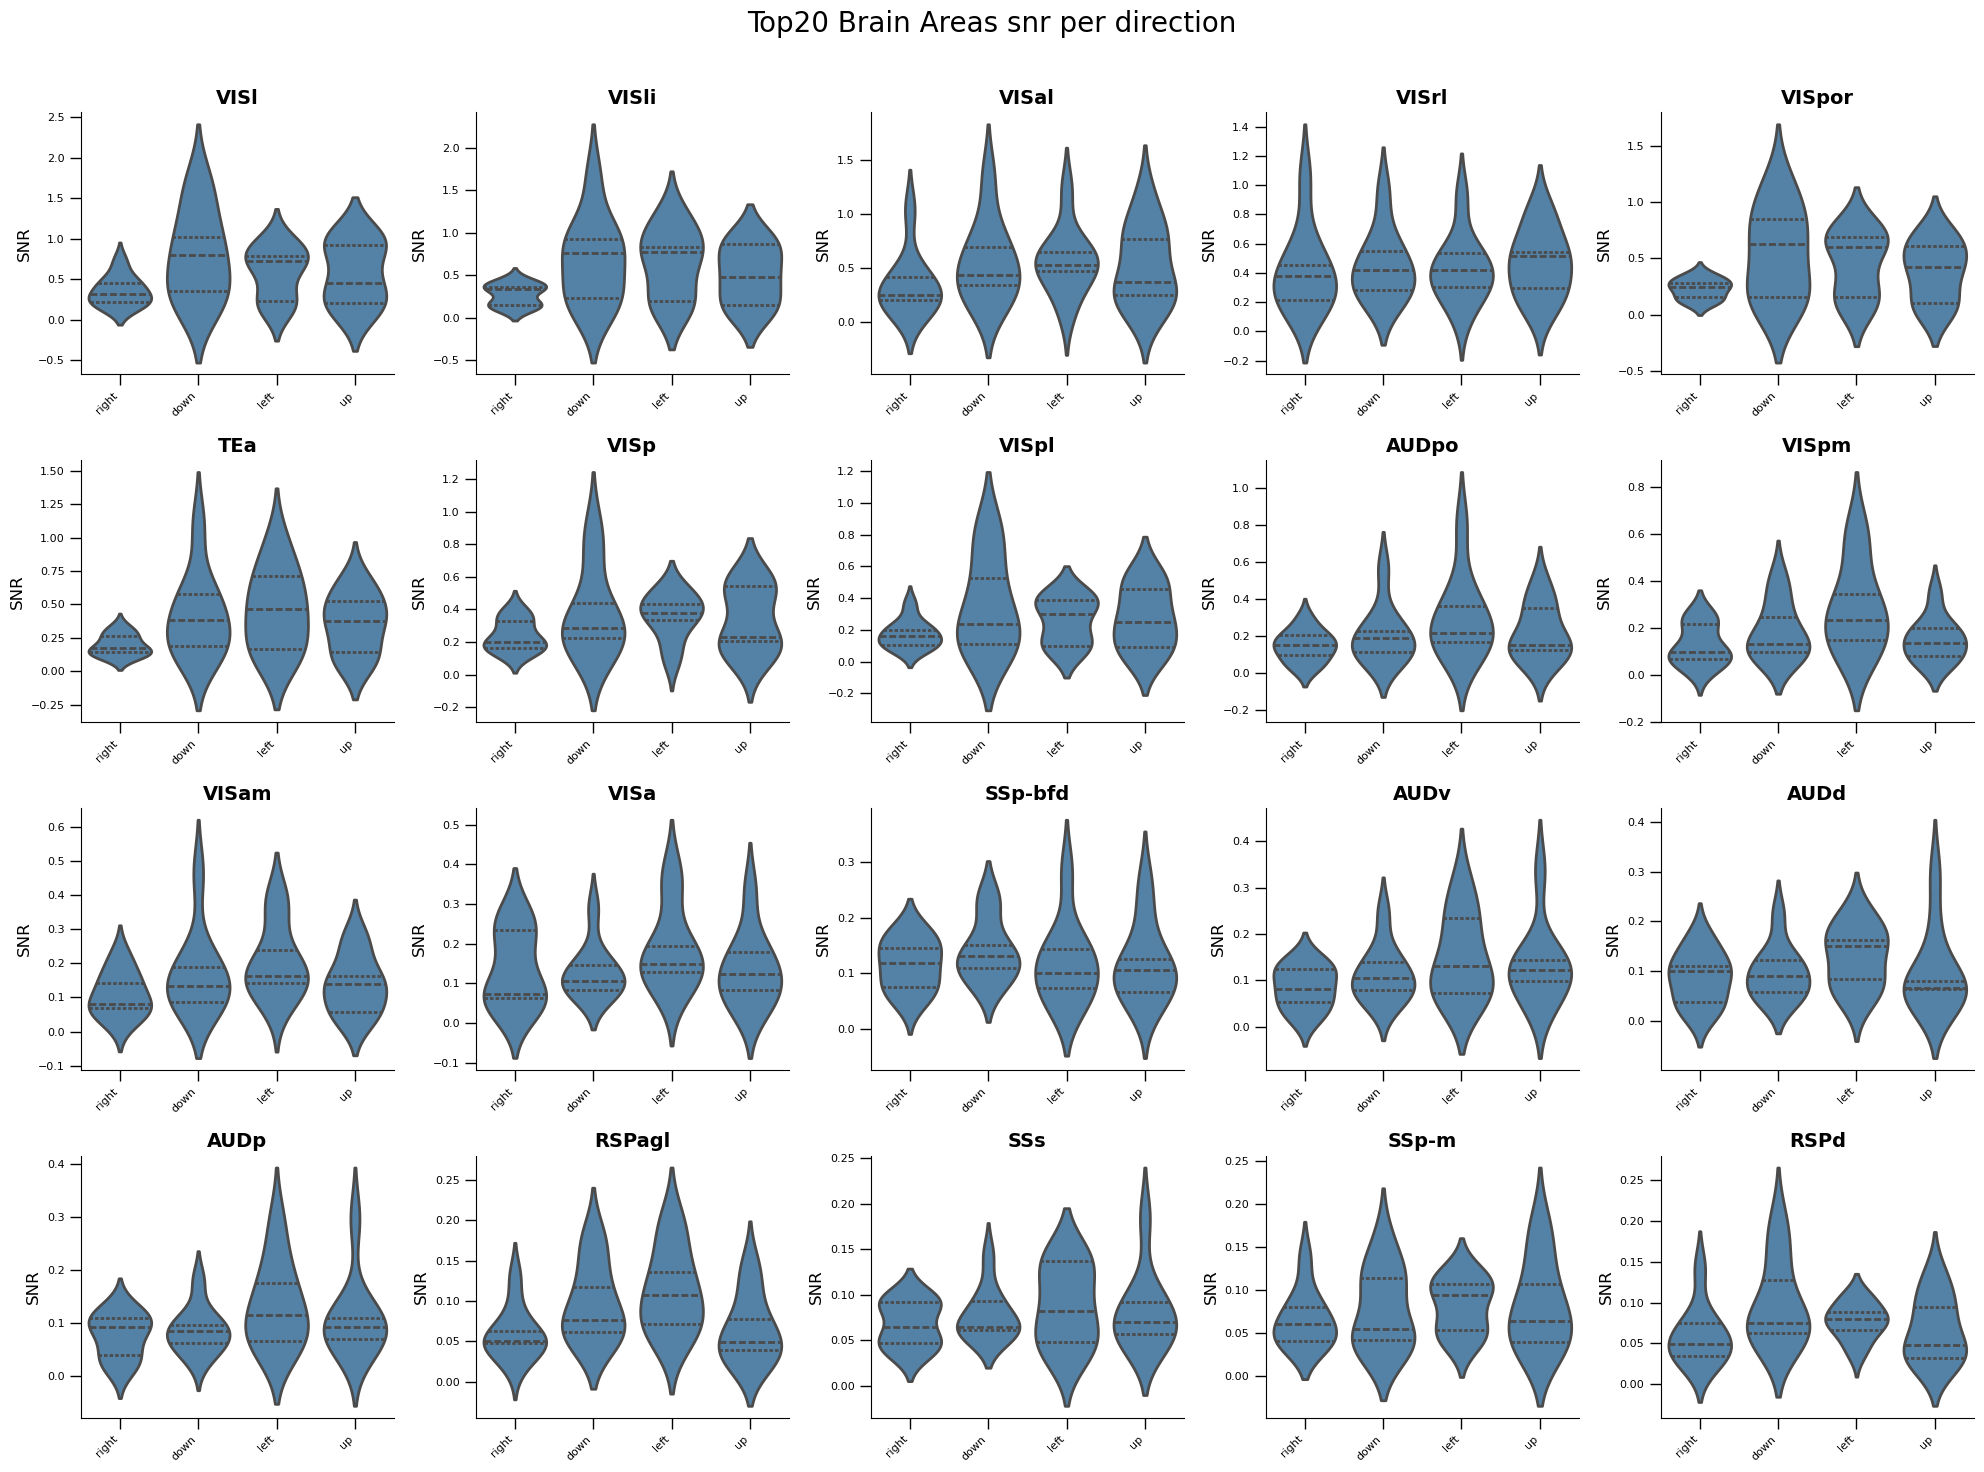

In [45]:


# 选出平均反应最强的 20 个脑区的索引
top_20_indices = np.argsort(all_area_snr.mean(axis=(1, 2)))[-20:][::-1]  # 从大到小排序取前 20
top_20_areas = [area_list[i] for i in top_20_indices]

# 创建子图
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
axes = axes.flatten()  # 将子图展平成一维数组，方便迭代

for idx, area_idx in enumerate(top_20_indices):  # 遍历前 20 个脑区
    # 提取当前脑区的数据
    data = all_area_snr[area_idx, :, :]  # (重复数, 视频数)
    df = pd.DataFrame(data, columns=direction_list)  # 将视频作为列
    df_long = df.melt(var_name='Movies', value_name='SNR')  # 转为长格式
    
    # sns.boxplot(x='Movies', y='SNR', data=df_long, ax=axes[idx])
    sns.violinplot(x='Movies', y='SNR', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')      
    axes[idx].set_title(top_20_areas[idx])  # 设置小标题为脑区名
    axes[idx].set_xlabel('')  # 隐藏 x 轴标签
    axes[idx].set_ylabel('SNR')  # y 轴标签保持为 SNR
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)  # 设置刻度字体大小
    for label in axes[idx].get_xticklabels():
        label.set_ha('right')  # 设置 x 轴标签右对齐
        
# 删除多余的子图（如果脑区小于 20）
for j in range(len(top_20_indices), len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('Top20 Brain Areas snr per direction', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'top20_areas_snr_per_direction.png'), facecolor='white', transparent=False)
plt.show()


## summary std

In [51]:
path_std_ls = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/*/moving-bar/process', '*-mvbar--', '*std_warped.npy'))
print(f'{len(path_std_ls)} std_warped.npy\n\n'+'\n'.join(path_std_ls))


9 std_warped.npy

/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/moving-bar/process/20241219-204729-mvbar--/P41_20241219-204729_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/moving-bar/process/20250110-013023-mvbar--/P41_20250110-013023_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/moving-bar/process/20250110-202214-mvbar--/U26_20250110-202214_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/moving-bar/process/20250110-214124-mvbar--/U27_20250110-214124_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/moving-bar/process/20250111-214213-mvbar--/U26_20250111-214213_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-071654-mvbar--/Q12_20250112-071654_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-072327-mvbar--/Q12_20250112-072327_std_warped.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/moving-bar/process/20250112-022646-mvbar--/U27_20250112-022646_std_warped.npy
/home/

In [64]:
## cal all std

std_list = [np.load(path_std) for path_std in path_std_ls]
std_array = np.asarray(std_list)
print('std_array.shape', std_array.shape)

np.save(pjoin(path_summary,'all_std.npy'), std_array)

std_array.shape (9, 540, 640, 4)


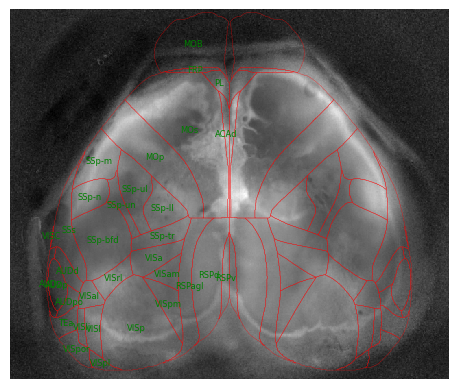

In [53]:
# plot warped avg_frame & CCF

fig = plt.figure()
plt.imshow(std_array[0, :, :, 0], cmap='gray')  # 将 snr_array 替换为 std_array
# plt.imshow(brain_mask, cmap='gray')

for i, r in ccf_regions.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=6, alpha=1, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.show()



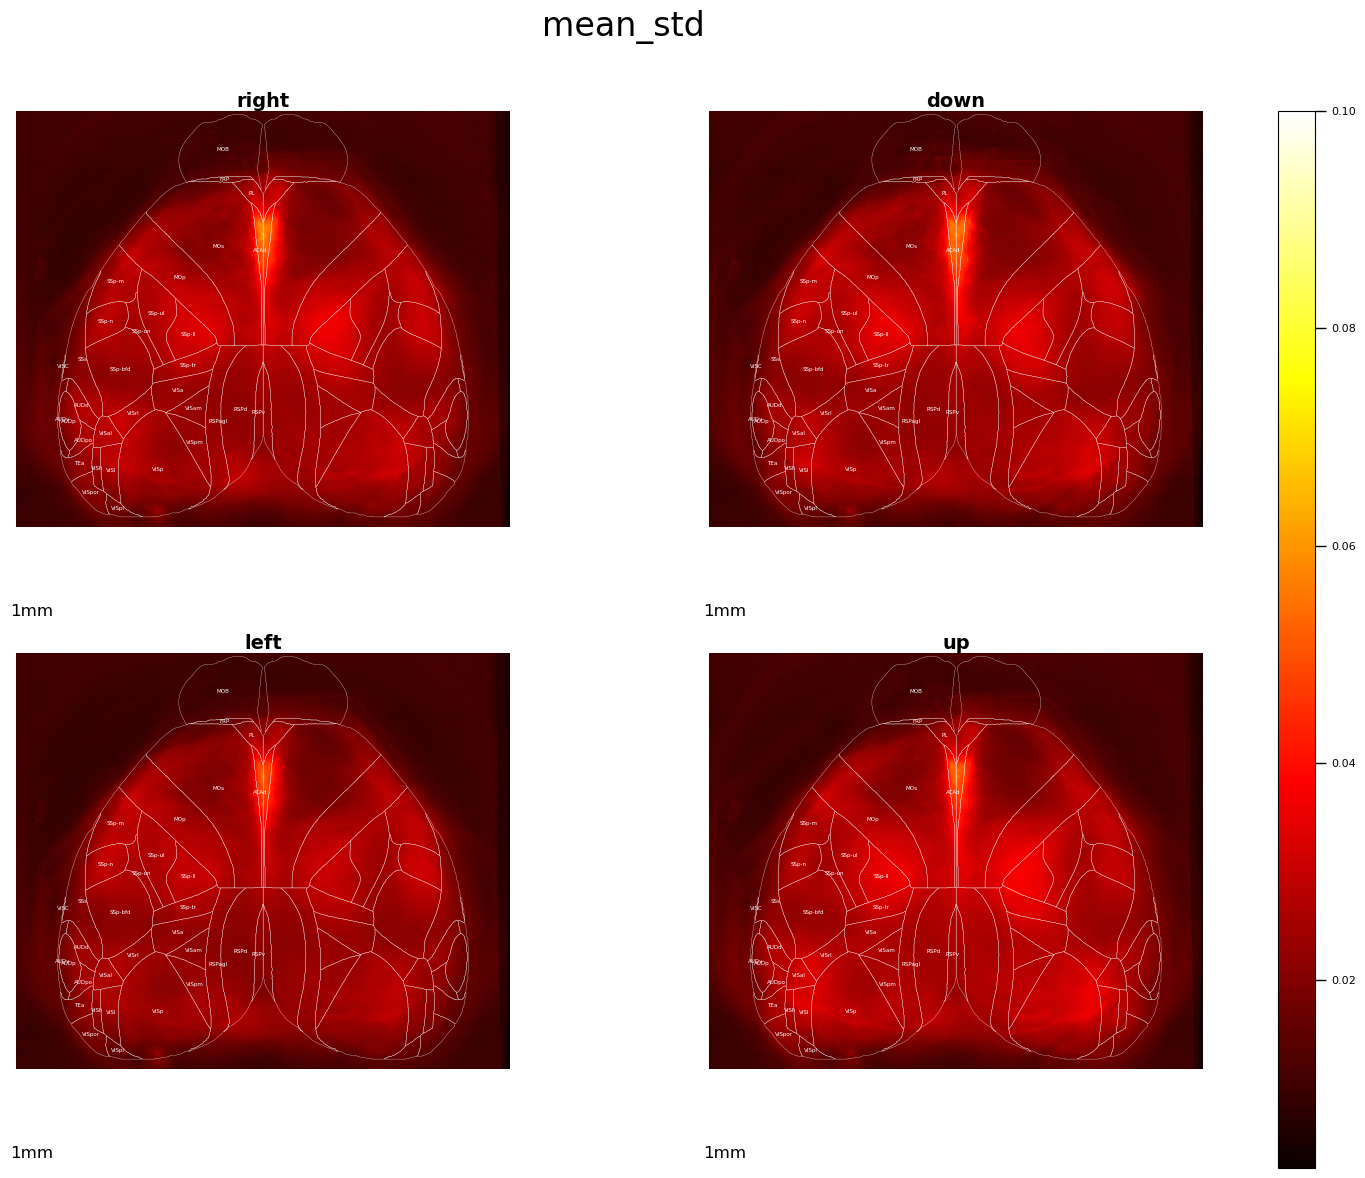

In [54]:

subplot_movie_heatmap(std_array.mean(axis=0), 2, 2, direction_list, path_outfile=pjoin(path_summary, 'mean_std.png'),
                      title='mean_std', vmax=0.1, pixel_um=26, patches=None,
                      ccf_regions=ccf_regions)



In [55]:
def flat_mask_warped(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,warped_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,warped_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(warped_height, warped_width))
    t = Uflat[idx,:]
    return t

std_array_flat= std_array.transpose(1,2,0,3).reshape(warped_height*warped_width, n_experiment*n_stim)
all_area_std =np.empty((33, std_array_flat.shape[-1]))

for area in range(1,34):
    all_area_std[area-1] = flat_mask_warped(std_array_flat, np.where(atlas == area)).mean(axis=0)
all_area_std = all_area_std.reshape(33, n_experiment, n_stim)

np.save(pjoin(path_summary, 'all_area_std.npy'), all_area_std)

/tmp/ipykernel_3935390/2759994532.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='std', data=df_long, order=None, scale='width', inner='quartile', color='steelblue')   # 绘制小提琴图


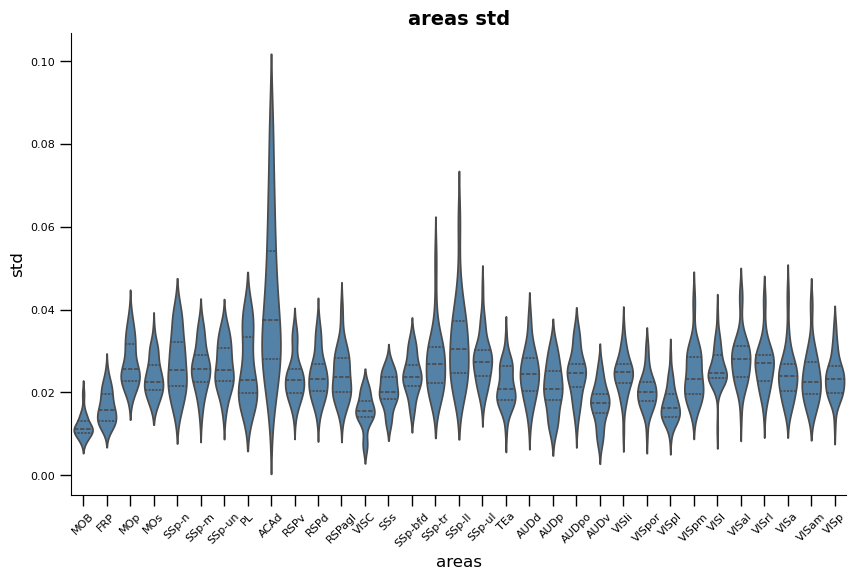

In [56]:

# 将矩阵转换为 DataFrame
df = pd.DataFrame(all_area_std.reshape(33, -1).T, columns=area_list)

# 将数据转换为长格式
df_long = df.melt(var_name='areas', value_name='std')

# 按每组的平均值对分组排序
group_order = df.mean(axis=0).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
# sns.boxplot(x='areas', y='std', data=df_long, order=group_order)
# sns.violinplot(x='areas', y='std', data=df_long, order=group_order, scale='width', inner='quartile')   # 绘制小提琴图
sns.violinplot(x='areas', y='std', data=df_long, order=None, scale='width', inner='quartile', color='steelblue')   # 绘制小提琴图
plt.title('areas std')
plt.xlabel('areas')
plt.ylabel('std')
plt.xticks(rotation=45)
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
# plt.savefig(pjoin(path_summary, 'all areas std rank.png'), facecolor='white', transparent=False)
plt.savefig(pjoin(path_summary, 'all areas std.png'), facecolor='white', transparent=False)
plt.show()


/tmp/ipykernel_3935390/1069286035.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='std', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')  # 替换 y='snr' 为 y='std'
/tmp/ipykernel_3935390/1069286035.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='std', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')  # 替换 y='snr' 为 y='std'
/tmp/ipykernel_3935390/1069286035.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='areas', y='std', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')  # 替换 y='snr' 为 y='std'
/tmp/ipykerne

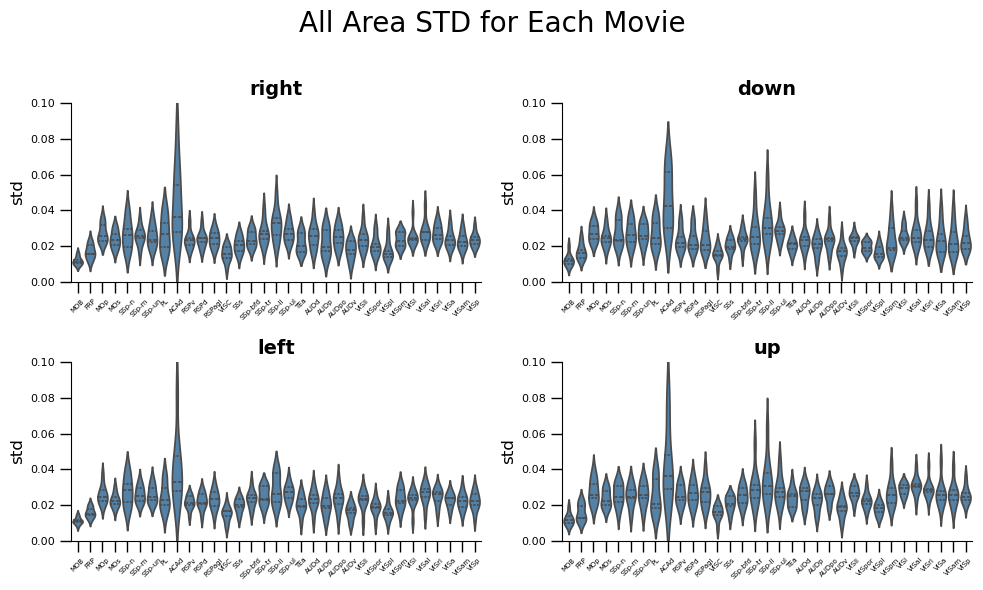

In [57]:


# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()  # 将 axes 二维数组展平，便于迭代
for i in range(n_stim):  # 遍历第三维的每个小图
    # 提取当前小图对应的数据
    matrix = all_area_std[:, :, i]  # 替换 all_area_snr 为 all_area_std
    df = pd.DataFrame(matrix.T, columns=area_list)
    
    # 转换为长格式
    df_long = df.melt(var_name='areas', value_name='std')

    # sns.boxplot(x='areas', y='std', data=df_long, order=None, ax=axes[i])
    sns.violinplot(x='areas', y='std', data=df_long, order=None, ax=axes[i], scale='width', inner='quartile', color='steelblue')  # 替换 y='snr' 为 y='std'
    axes[i].set_title(direction_list[i])  # 设置小标题
    axes[i].set_xlabel('')  # 隐藏 x 轴标签以节省空间
    axes[i].set_ylabel('std')  # 替换 y 轴标签为 std
    axes[i].set_ylim(0, 0.1)  # 设置统一 y 轴范围
    axes[i].tick_params(axis='x', rotation=45, labelsize=5)  # 调整刻度角度和字体大小

# 删除多余的子图（仅 14 个小图）
for j in range(14, len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('All Area STD for Each Movie', fontsize=20)  # 替换标题中的 SNR 为 STD
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'all_areas_std_per_direction_unified_y_violin.png'), facecolor='white', transparent=False)  # 替换文件名
plt.show()



/tmp/ipykernel_3935390/91746596.py:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Movies', y='STD', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')  # 替换 y='SNR' 为 y='STD'
/tmp/ipykernel_3935390/91746596.py:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Movies', y='STD', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')  # 替换 y='SNR' 为 y='STD'
/tmp/ipykernel_3935390/91746596.py:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Movies', y='STD', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')  # 替换 y='SNR' 为 y='STD'
/tmp/ip

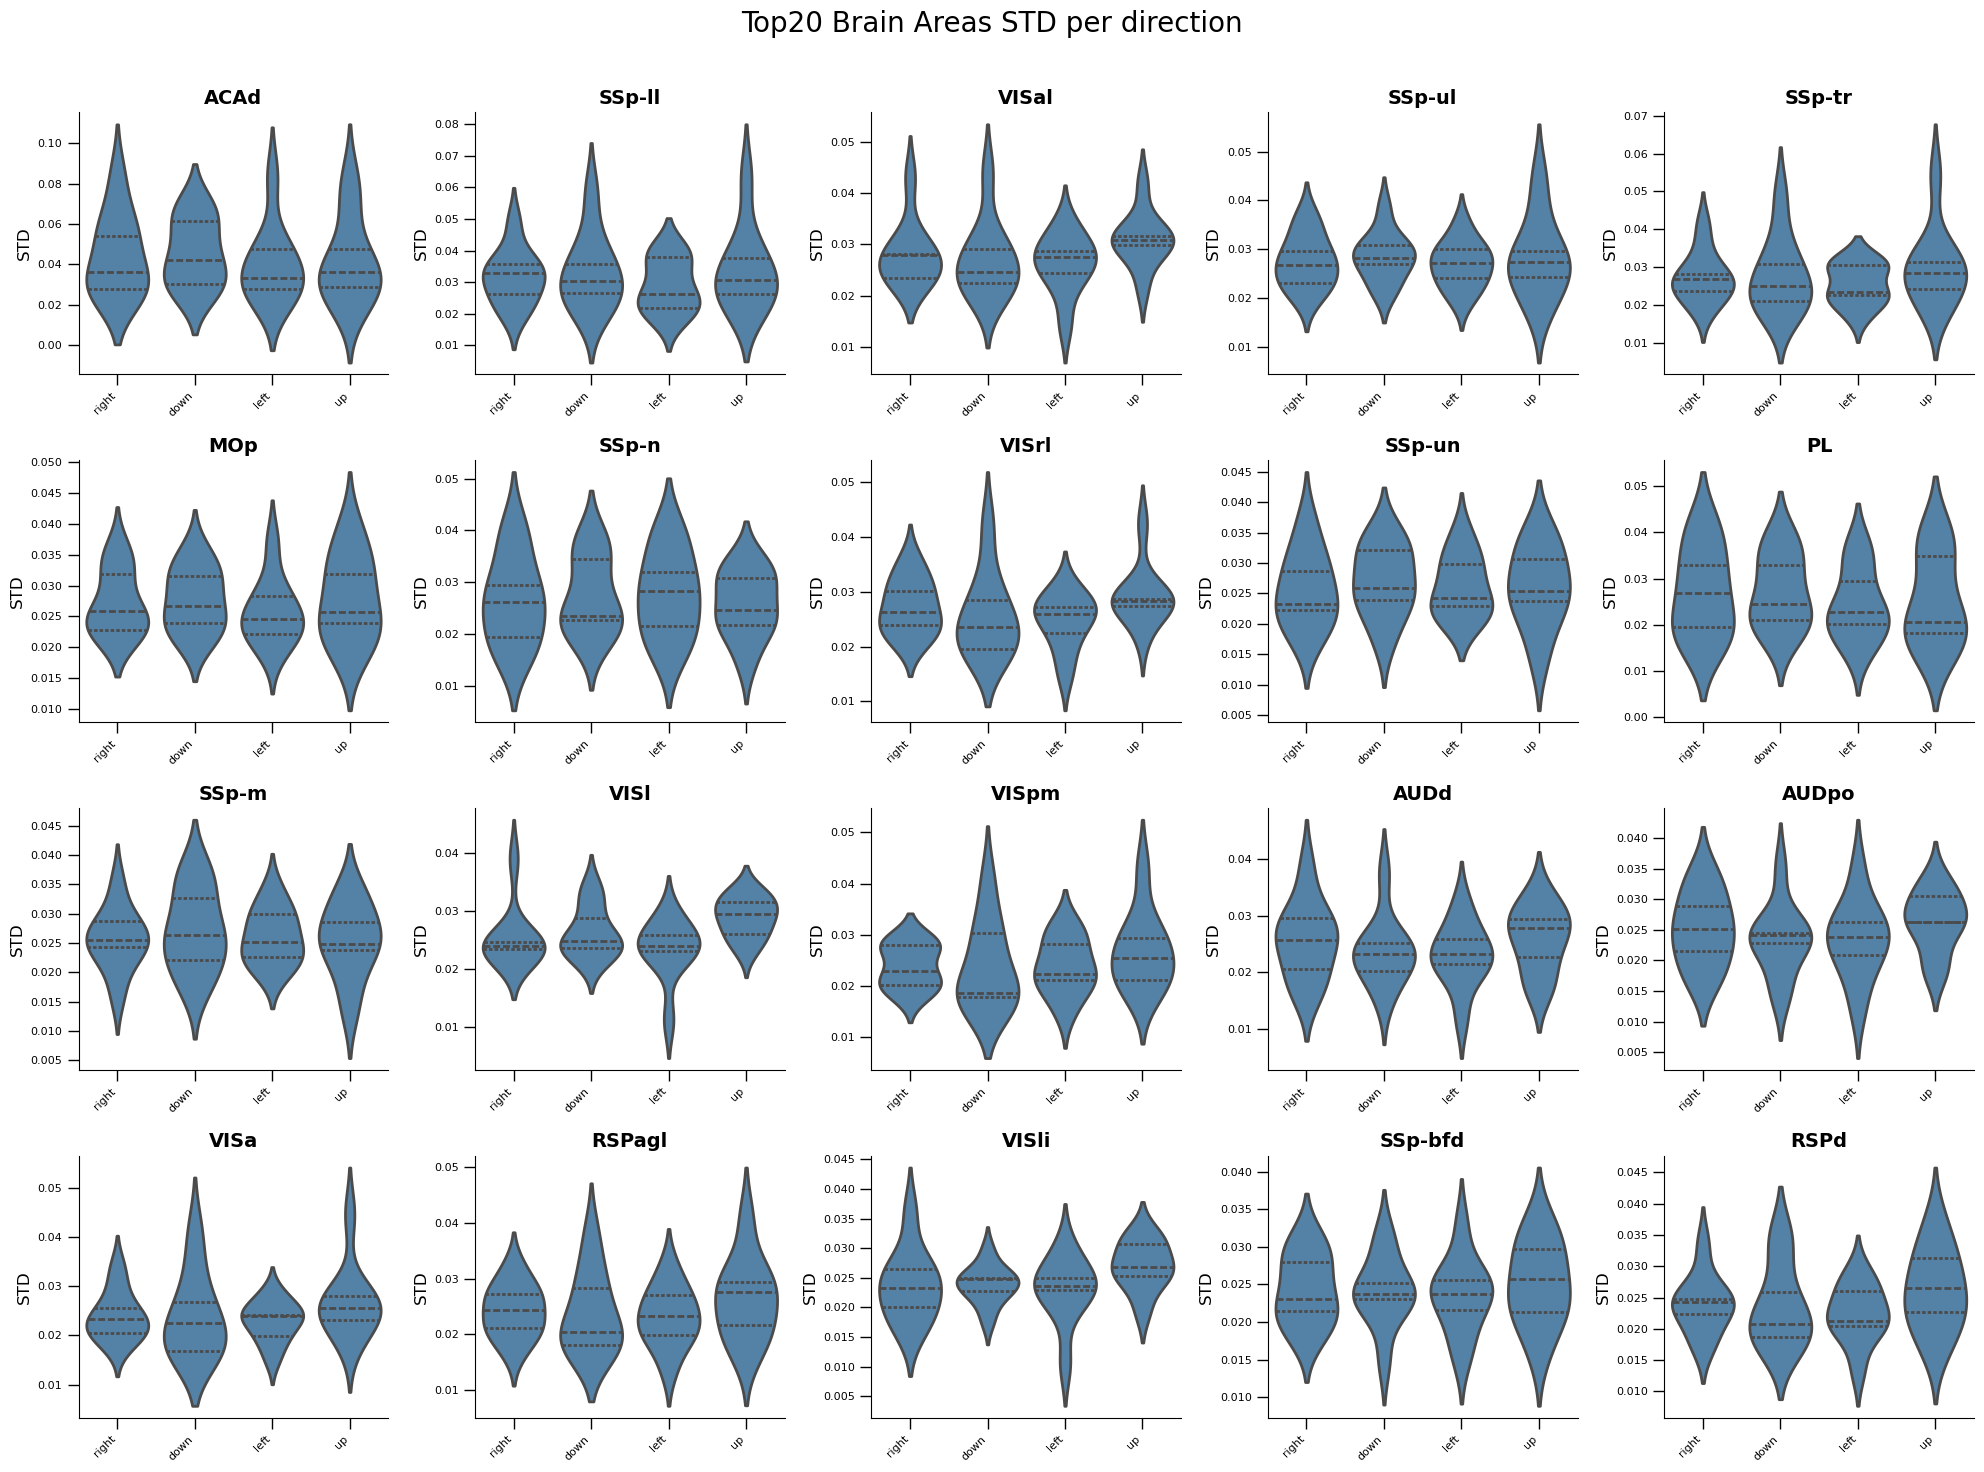

In [58]:

# 选出平均反应最强的 20 个脑区的索引
top_20_indices = np.argsort(all_area_std.mean(axis=(1, 2)))[-20:][::-1]  # 替换 all_area_snr 为 all_area_std
top_20_areas = [area_list[i] for i in top_20_indices]

# 创建子图
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
axes = axes.flatten()  # 将子图展平成一维数组，方便迭代

for idx, area_idx in enumerate(top_20_indices):  # 遍历前 20 个脑区
    # 提取当前脑区的数据
    data = all_area_std[area_idx, :, :]  # 替换 all_area_snr 为 all_area_std
    df = pd.DataFrame(data, columns=direction_list)  # 将视频作为列
    df_long = df.melt(var_name='Movies', value_name='STD')  # 替换 SNR 为 STD
    
    # sns.boxplot(x='Movies', y='STD', data=df_long, ax=axes[idx])
    sns.violinplot(x='Movies', y='STD', data=df_long, ax=axes[idx], scale='width', inner='quartile', linewidth=2, color='steelblue')  # 替换 y='SNR' 为 y='STD'
    axes[idx].set_title(top_20_areas[idx])  # 设置小标题为脑区名
    axes[idx].set_xlabel('')  # 隐藏 x 轴标签
    axes[idx].set_ylabel('STD')  # 替换 y 轴标签为 STD
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)  # 设置刻度字体大小
    for label in axes[idx].get_xticklabels():
        label.set_ha('right')  # 设置 x 轴标签右对齐

# 删除多余的子图（如果脑区小于 20）
for j in range(len(top_20_indices), len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('Top20 Brain Areas STD per direction', fontsize=20)  # 替换标题中的 SNR 为 STD
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'top20_areas_std_per_direction.png'), facecolor='white', transparent=False)  # 替换文件名
plt.show()


## summary area correlation

In [66]:
path_correlation_ls = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/*/moving-bar/process', '*-mvbar--', '*all area correlation.npy'))
print(f'{len(path_correlation_ls)} all_area_correlation.npy\n\n'+'\n'.join(path_correlation_ls))


9 all_area_correlation.npy

/home/lzx/data/WF_VC_liuzhaoxi/24.12.19_P41/moving-bar/process/20241219-204729-mvbar--/P41_20241219-204729_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_P41/moving-bar/process/20250110-013023-mvbar--/P41_20250110-013023_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U26/moving-bar/process/20250110-202214-mvbar--/U26_20250110-202214_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.10_U27/moving-bar/process/20250110-214124-mvbar--/U27_20250110-214124_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.11_U26/moving-bar/process/20250111-214213-mvbar--/U26_20250111-214213_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-071654-mvbar--/Q12_20250112-071654_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_Q12/moving-bar/process/20250112-072327-mvbar--/Q12_20250112-072327_all area correlation.npy
/home/lzx/data/WF_VC_liuzhaoxi/25.01.12_U27/movi

In [67]:
correlation_list = [np.load(path_correlation) for path_correlation in path_correlation_ls]
correlation_array = np.asarray(correlation_list)
print('correlation_array.shape', correlation_array.shape)

np.save(pjoin(path_summary,'all_area_correlation.npy'), correlation_array)

correlation_array.shape (9, 33, 33)


In [62]:
area_list1 = ['MOB','FRP','MOp','MOs','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSp-n','SSp-m','SSp-un','SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

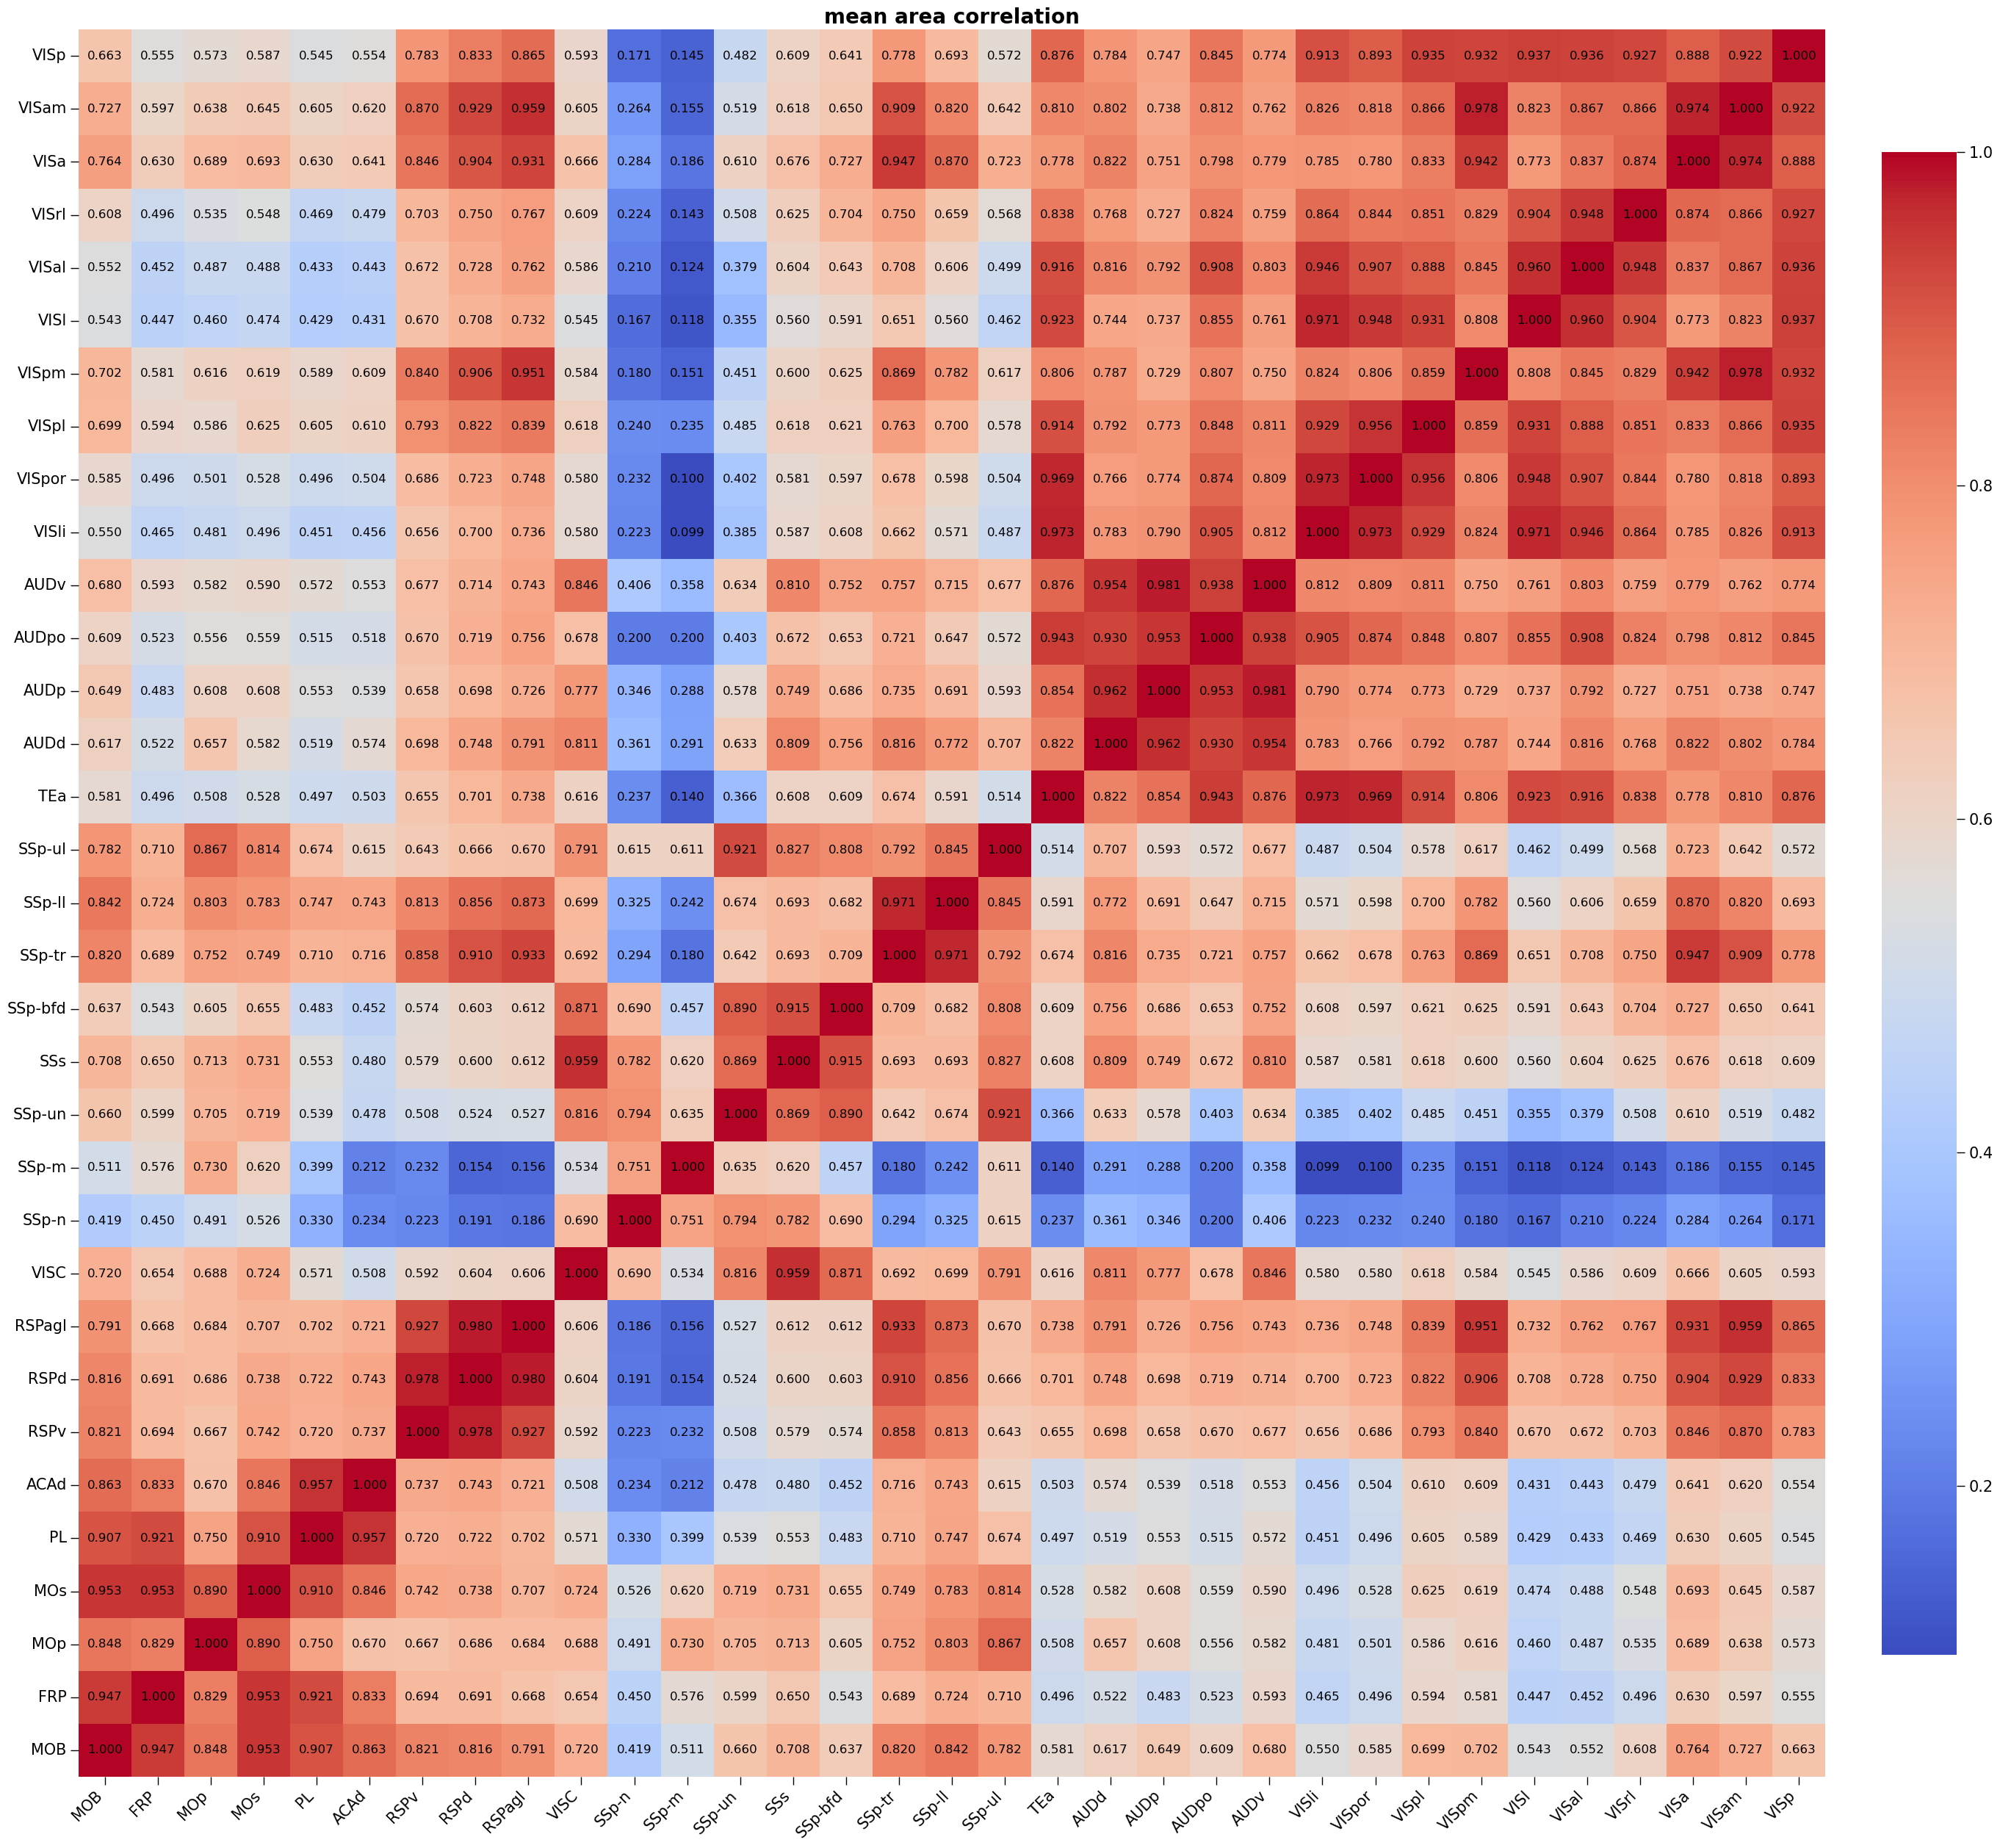

In [63]:
plot_heatmap(correlation_array.mean(axis=0), xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title='mean area correlation', 
             outfile=pjoin(path_summary,'mean area correlation.png'), dpi=300, annot=True)